In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from models.custom_cnn import initialize_custom_cnn
from models.efficientnet import initialize_efficientnet
from models.resnet18 import initialize_resnet18
import pandas as pd
from torchvision.datasets import ImageFolder
from PIL import Image

print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Amount of CUDA devices available: {torch.cuda.device_count()}")
print(f"Index of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Amount of CPUs available: {os.cpu_count()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = os.cpu_count()

/home/olejohanjo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available: True
Amount of CUDA devices available: 1
Index of current CUDA device: 0
Name of current CUDA device: Tesla V100-SXM3-32GB
Amount of CPUs available: 96


In [25]:
# Data directories
data_dirs = {
    'synthetic': 'prepared_data/gen',
    'real': 'prepared_data/train'
}
test_data_dir = 'prepared_data/test'

# Categories
categories = [
    "village",
    "vineyard",
    "nursery",
    "b_hall",
    "beach",
    "k_class",
    "e_lobby",
    "m_water",
    "islet",
    "shopfront"
]
num_classes = len(categories)

# Training parameters
batch_size = 512
num_epochs = 200
learning_rate = 1e-4

# Data transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]  # ImageNet std
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]  # ImageNet std
        )
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]  # ImageNet std
        )
    ]),
}


In [3]:
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.image_folder = ImageFolder(root=root)
        self.transform = transform
        self.samples = self.image_folder.samples
        self.classes = self.image_folder.classes
        self.class_to_idx = self.image_folder.class_to_idx

        # Preload images into memory
        self.data = []
        self.targets = []
        print(f"Loading dataset from {root} into memory...")
        for path, target in self.samples:
            image = Image.open(path).convert('RGB')
            if self.transform is not None:
                image = self.transform(image)
            self.data.append(image)
            self.targets.append(target)
        print(f"Loaded {len(self.data)} images.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        target = self.targets[index]
        return image, target

In [4]:
datasets_dict = {}
dataloaders_dict = {}
dataset_sizes = {}

for dataset_type in ['synthetic', 'real']:
    # Load the dataset into memory
    dataset = InMemoryDataset(
        root=data_dirs[dataset_type],
        transform=data_transforms['train']
    )

    # Split into training and validation sets
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # to seed or not to seed?
    )

    datasets_dict[dataset_type] = {
        'train': train_dataset,
        'val': val_dataset
    }
    dataset_sizes[dataset_type] = {
        'train': train_size,
        'val': val_size
    }

    # Create data loaders
    dataloaders_dict[dataset_type] = {
        'train': DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,  # no workers because data is already in memory
            pin_memory=True
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,  # no workers because data is already in memory
            pin_memory=True
        )
    }

    print(f"{dataset_type.capitalize()} dataset sizes - Train: {train_size}, Validation: {val_size}")

# Load the test dataset into memory
test_dataset = InMemoryDataset(
    root=test_data_dir,
    transform=data_transforms['test']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # no workers because data is already in memory
    pin_memory=True
)
print(f"Testing dataset size: {len(test_dataset)}")

Loading dataset from prepared_data/gen into memory...
Loaded 9990 images.
Synthetic dataset sizes - Train: 7992, Validation: 1998
Loading dataset from prepared_data/train into memory...
Loaded 9990 images.
Real dataset sizes - Train: 7992, Validation: 1998
Loading dataset from prepared_data/test into memory...
Loaded 1008 images.
Testing dataset size: 1008


In [15]:
models_dict = {}
optimizers_dict = {}
schedulers_dict = {}

model_initializers = {
    'ResNet18': initialize_resnet18,
    'EfficientNet': initialize_efficientnet,
    'CustomCNN': initialize_custom_cnn
}

weights_dir = 'weights'

for model_name, initializer in model_initializers.items():
    for dataset_type in ['synthetic', 'real']:
        # Initialize the model
        model = initializer(num_classes)
        model = model.to(device, non_blocking=True)
        models_dict[(model_name, dataset_type)] = model

        # Load weights if available
        weight_file = os.path.join(weights_dir, f"best_{model_name}_{dataset_type}.pth")
        if os.path.exists(weight_file):
            model.load_state_dict(torch.load(weight_file, map_location=device))
            print(f"Loaded weights for {model_name} ({dataset_type}) from {weight_file}")
        else:
            print(f"No weights found for {model_name} ({dataset_type}). Using untrained model.")

        # Adjust learning rate based on model type
        if model_name == 'ResNet18':
            learning_rate = 0.0001
        elif model_name == 'EfficientNet':
            learning_rate = 0.0001
        else:
            learning_rate = 0.001

        # Initialize the optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        optimizers_dict[(model_name, dataset_type)] = optimizer

        # Initialize the scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)
        schedulers_dict[(model_name, dataset_type)] = scheduler


No weights found for ResNet18 (synthetic). Using untrained model.
No weights found for ResNet18 (real). Using untrained model.
No weights found for EfficientNet (synthetic). Using untrained model.
No weights found for EfficientNet (real). Using untrained model.
No weights found for CustomCNN (synthetic). Using untrained model.
No weights found for CustomCNN (real). Using untrained model.


In [16]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, model_name, dataset_type, patience):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    epochs_no_improve = 0
    early_stop = False

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping...")
            break
        print()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Add to history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'train':
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
                print(f'  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    os.makedirs('weights', exist_ok=True)
                    torch.save(best_model_wts, f'weights/best_{model_name}_{dataset_type}.pth')
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        early_stop = True
                        break

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [17]:
# Train Models
criterion = nn.CrossEntropyLoss()
training_histories = {}

for model_name, initializer in model_initializers.items():
    for dataset_type in ['synthetic', 'real']:
        print(f"Training {model_name} on {dataset_type} data")
        model = models_dict[(model_name, dataset_type)]
        optimizer = optimizers_dict[(model_name, dataset_type)]
        scheduler = schedulers_dict[(model_name, dataset_type)]
        dataloaders = dataloaders_dict[dataset_type]

        # Train the model
        model, history = train_model(
            model,
            dataloaders,
            criterion,
            optimizer,
            scheduler,
            num_epochs,
            model_name,
            dataset_type,
            patience=10
        )
        models_dict[(model_name, dataset_type)] = model  # Update the model with trained weights

        # Store training history for this model and dataset type
        training_histories[(model_name, dataset_type)] = history


Training ResNet18 on synthetic data

Epoch 1/200
----------
train Loss: 2.3871 Acc: 0.1944
  val Loss: 2.2860 Acc: 0.2232

Epoch 2/200
----------
train Loss: 2.1656 Acc: 0.2767
  val Loss: 2.0846 Acc: 0.3058

Epoch 3/200
----------
train Loss: 1.9922 Acc: 0.3712
  val Loss: 1.9162 Acc: 0.4114

Epoch 4/200
----------
train Loss: 1.8347 Acc: 0.4732
  val Loss: 1.7650 Acc: 0.5205

Epoch 5/200
----------
train Loss: 1.6903 Acc: 0.5726
  val Loss: 1.6259 Acc: 0.6136

Epoch 6/200
----------
train Loss: 1.5604 Acc: 0.6622
  val Loss: 1.5011 Acc: 0.6822

Epoch 7/200
----------
train Loss: 1.4409 Acc: 0.7217
  val Loss: 1.3867 Acc: 0.7342

Epoch 8/200
----------
train Loss: 1.3348 Acc: 0.7634
  val Loss: 1.2859 Acc: 0.7743

Epoch 9/200
----------
train Loss: 1.2406 Acc: 0.7940
  val Loss: 1.1952 Acc: 0.8018

Epoch 10/200
----------
train Loss: 1.1532 Acc: 0.8198
  val Loss: 1.1139 Acc: 0.8253

Epoch 11/200
----------
train Loss: 1.0768 Acc: 0.8385
  val Loss: 1.0412 Acc: 0.8408

Epoch 12/200
--

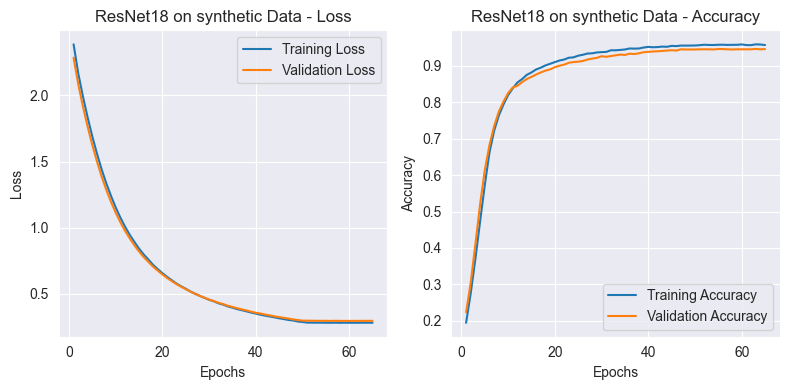

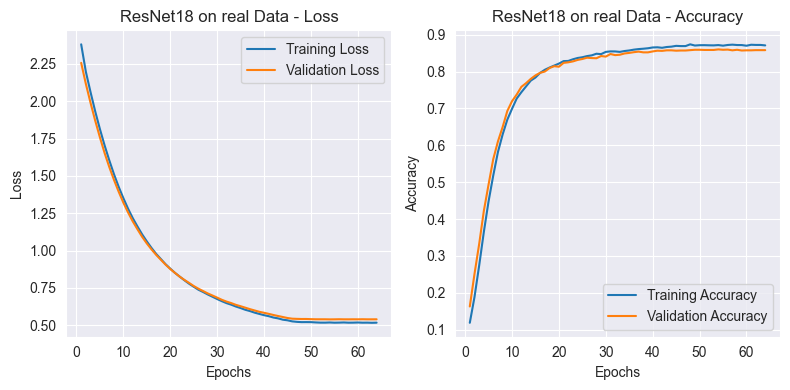

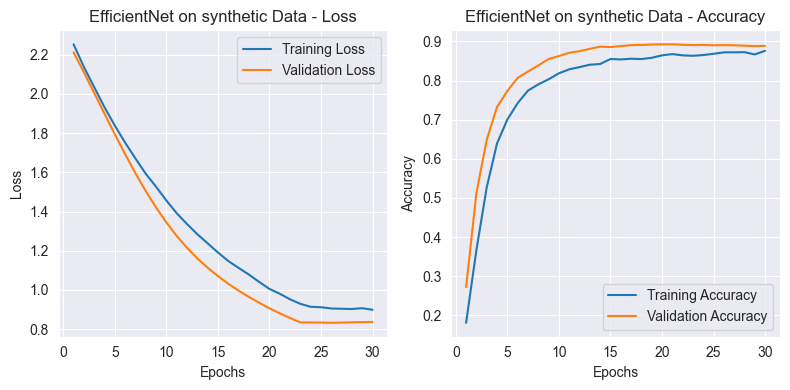

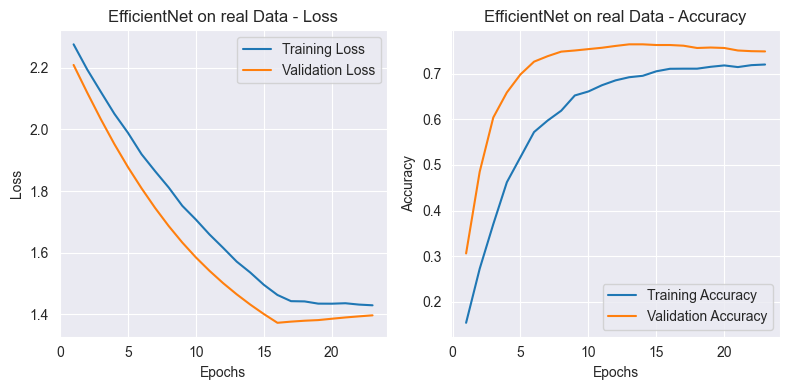

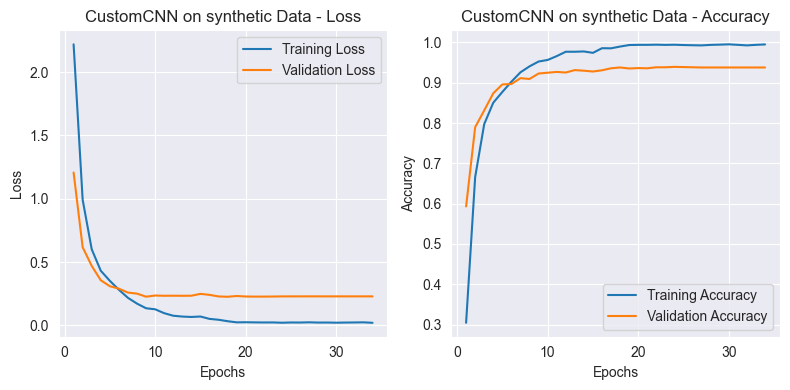

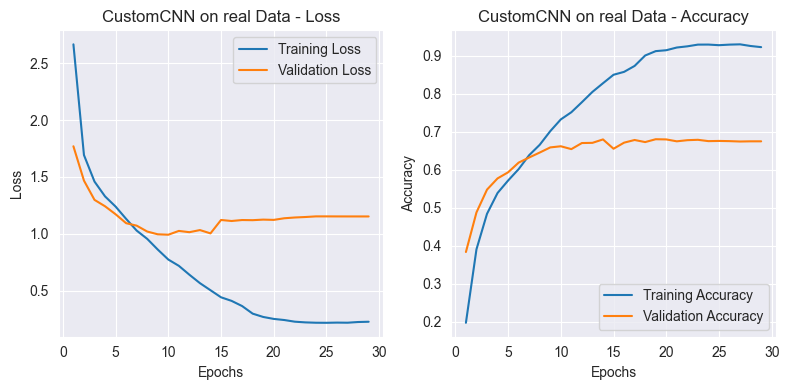

In [18]:
# Plotting function
def plot_training_history(history, model_name, dataset_type):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} on {dataset_type} Data - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} on {dataset_type} Data - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot training history for each model and dataset
for (model_name, dataset_type), history in training_histories.items():
    plot_training_history(history, model_name, dataset_type)


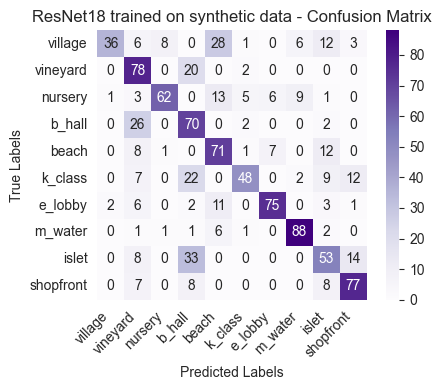

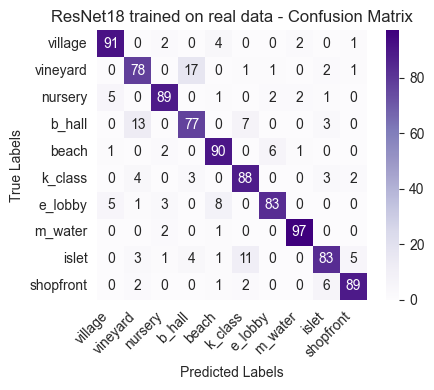

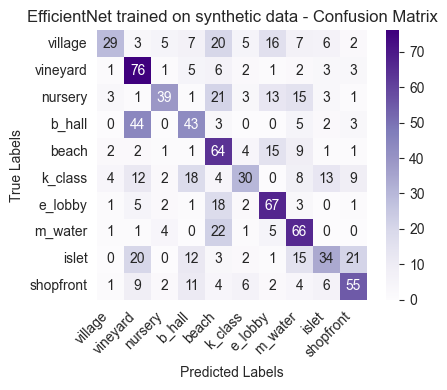

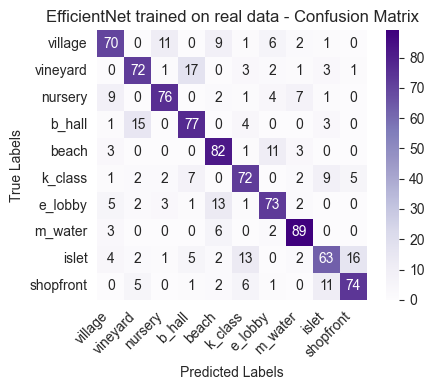

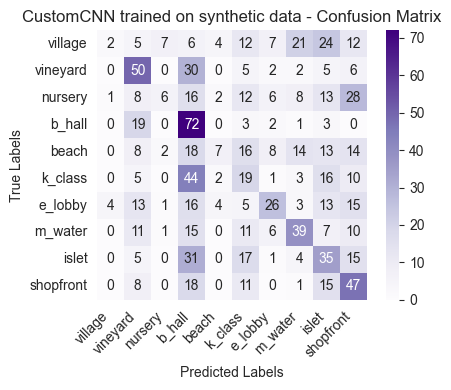

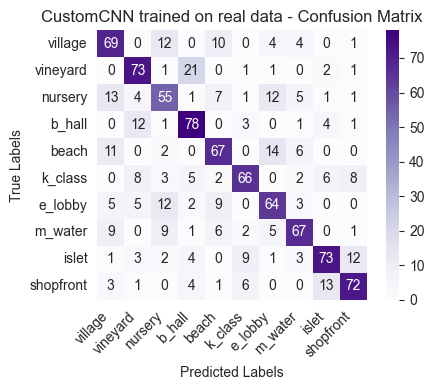

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, dataloader, model_name, dataset_type, categories):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Create heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,  # Add numbers in cells
        fmt='d',  # Integer format
        cmap='Purples',  # Color map
        xticklabels=categories,
        yticklabels=categories,
        cbar=True,
        square=True
    )
    plt.title(f'{model_name} trained on {dataset_type} data - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to avoid label cutoff
    plt.show()


# Generate confusion matrices for all models and dataset types
for model_name in model_initializers.keys():
    for dataset_type in ['synthetic', 'real']:
        model = models_dict[(model_name, dataset_type)]
        plot_confusion_matrix(model, test_loader, model_name, dataset_type, categories)


In [27]:
from sklearn.metrics import classification_report


def print_classification_report(model, dataloader, model_name, dataset_type):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=categories)
    print(f'Classification Report for {model_name} trained on {dataset_type} data:')
    print(report)


# Generate classification reports
for model_name in model_initializers.keys():
    for dataset_type in ['synthetic', 'real']:
        model = models_dict[(model_name, dataset_type)]
        print_classification_report(model, test_loader, model_name, dataset_type)


Classification Report for ResNet18 trained on synthetic data:
              precision    recall  f1-score   support

     village       0.92      0.36      0.52       100
    vineyard       0.52      0.78      0.62       100
     nursery       0.86      0.62      0.72       100
      b_hall       0.45      0.70      0.55       100
       beach       0.55      0.71      0.62       100
     k_class       0.80      0.48      0.60       100
     e_lobby       0.85      0.75      0.80       100
     m_water       0.84      0.88      0.86       100
       islet       0.52      0.49      0.50       108
   shopfront       0.72      0.77      0.74       100

    accuracy                           0.65      1008
   macro avg       0.70      0.65      0.65      1008
weighted avg       0.70      0.65      0.65      1008

Classification Report for ResNet18 trained on real data:
              precision    recall  f1-score   support

     village       0.89      0.91      0.90       100
    vineyard 

In [28]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_acc

In [29]:
results = []

for model_name in model_initializers.keys():
    for dataset_type in ['synthetic', 'real']:
        model = models_dict[(model_name, dataset_type)]
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        results.append({
            'Model': model_name,
            'Dataset': dataset_type,
            'Testing Loss': test_loss,
            'Testing Accuracy': test_acc.item()
        })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


          Model    Dataset  Testing Loss  Testing Accuracy
0      ResNet18  synthetic      1.034146          0.652778
1      ResNet18       real      0.533281          0.858135
2  EfficientNet  synthetic      1.684638          0.499008
3  EfficientNet       real      1.373869          0.742063
4     CustomCNN  synthetic     10.408113          0.300595
5     CustomCNN       real      1.113745          0.678571
